In [10]:
from dgpsi import sexp_k_one_vector_derivative, gp, kernel, nb_seed
from mogp_emulator.ExperimentalDesign import LatinHypercubeDesign
import matplotlib.pyplot as plt
import numpy as np

nb_seed(17)
np.random.seed(17)

In [11]:
def test_f(x):
    return np.sin(2*x) + np.cos(3*x) + 0.1*np.sin(5*x)
def gradient_test_f(x):
    return 2*np.cos(2*x) - 3*np.sin(3*x) + 0.5*np.cos(5*x)


lhd = LatinHypercubeDesign([(-np.pi,np.pi)])

x_train = lhd.sample(12)
y_train = np.array(test_f(x_train))
gp_emu = gp(x_train, y_train, kernel(length=np.array([1]), name='sexp', scale_est=True))
gp_emu.train()

In [12]:
grid_eval_grid = np.linspace(-np.pi, np.pi, 100)

Z = test_f(grid_eval_grid)
grad_eval = gradient_test_f(grid_eval_grid)

pred_mu, _ = gp_emu.predict(grid_eval_grid[:,None])
nabla_r = sexp_k_one_vector_derivative(grid_eval_grid[:,None], x_train, 
                                       gp_emu.kernel.length, 1)

grad_pred = np.einsum('mnd,n->md', nabla_r, gp_emu.kernel.Rinv_y)

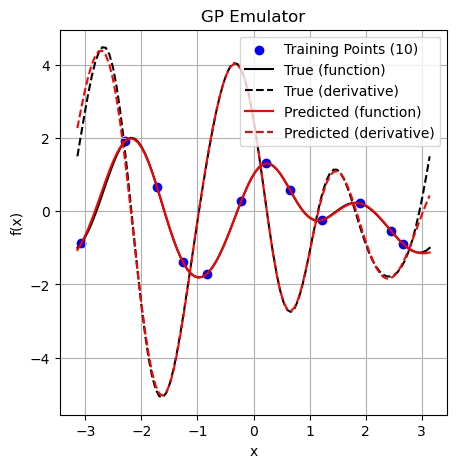

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(x_train, y_train, color='blue', label='Training Points (10)')


ax.plot(grid_eval_grid, Z, color='black', label='True (function)')
ax.plot(grid_eval_grid, grad_eval, linestyle='--', color='black', label='True (derivative)')


ax.plot(grid_eval_grid, pred_mu, color='red', label='Predicted (function)')
ax.plot(grid_eval_grid, grad_pred, linestyle='--', color='red', label='Predicted (derivative)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('GP Emulator')

plt.legend()
plt.grid()
plt.show()

### DGP Emulator

In [14]:
from dgpsi import dgp, kernel, combine, emulator, grad_lgp
import matplotlib.pyplot as plt
import numpy as np

In [15]:
y_train = np.array(test_f(x_train))
layer1=[kernel(length=np.array([1]),name='sexp', scale_est=True)]
layer2=[kernel(length=np.array([1]),name='sexp', scale_est=True)]
all_layer=combine(layer1,layer2)
m=dgp(x_train,y_train,all_layer)
m.train(N=100)
final_layer_obj=m.estimate()
# nb_seed(256)
emu=emulator(final_layer_obj,N=50)

Iteration 100: Layer 2: 100%|██████████| 100/100 [00:00<00:00, 123.98it/s]


In [16]:
pred_mu, pred_var = emu.predict(grid_eval_grid[:,None], full_layer=True)

In [17]:

grad_pred = np.zeros((100, 1))
num_imp = len(emu.all_layer_set)
for i in range(num_imp):
    tmp_grad_pred = grad_lgp(grid_eval_grid[:,None], emu.all_layer_set[i])
    grad_pred += tmp_grad_pred/num_imp
    

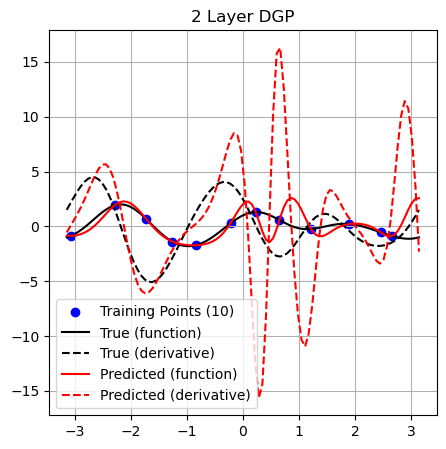

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(x_train, y_train, color='blue', label='Training Points (10)')


ax.plot(grid_eval_grid, Z, color='black', label='True (function)')
ax.plot(grid_eval_grid, grad_eval, linestyle='--', color='black', label='True (derivative)')


ax.plot(grid_eval_grid, pred_mu[1], color='red', label='Predicted (function)')
ax.plot(grid_eval_grid, grad_pred, linestyle='--', color='red', label='Predicted (derivative)')
plt.title('2 Layer DGP')

plt.legend()
plt.grid()
plt.show()